In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install scipy

In [2]:
import sys
sys.path.append("..")
from refldesign.problem import build_problem
from refldesign.solvers import sorted1d, sinkhorn_log, sinkhorn_stabilized
from refldesign.tools import approxmap, sinkhornplan, ctransform, cbartransform
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import numpy as np
from IPython.display import display, Markdown, Latex

import tensorflow as tf

We want to generate data for the 1D reflector problem.

We recall the problem can be posed as a optimal transport problem $\mathrm{OT}(\mu, \nu)$ under the cost $-\log(|x - y|)$ where $\mu$ is the source illumination, and $\nu$ is the target.

As a first approach, we propose to consider the $L_2$ cost instead, on a regular grid.

We can build some random example using the `build_problem` function.
As of now, the cost is the $\mathcal{L}_2$ norm, and the support of both distributions is $[0,1]$.

In [3]:
# We set grid dimensions
n, m = 256, 256

Below some examples of $\mu$, which are a normalized sum of 4 gaussian with varying standard deviation.

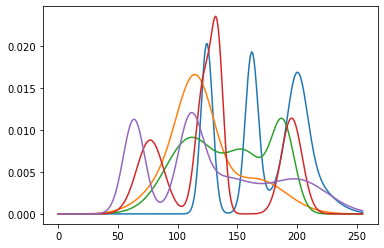

In [4]:
for i in range(5):
    C, a, b, mu, nu = build_problem(256,256)
    plt.plot(mu)

We will first demonstrate the solutions and effect of regularisation on a random example.Âµ

In [5]:
# Generate a random example
C, a, b, mu, nu = build_problem(n, m)

Below the input and output distributions for this example

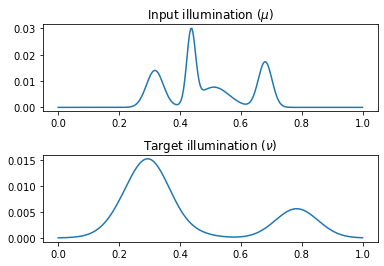

In [6]:
plt.subplot(2,1,1)
plt.title('Input illumination ($\\mu$)')
plt.plot(a, mu)

plt.subplot(2,1,2)
plt.title('Target illumination ($\\nu$)')
plt.plot(b, nu)

plt.subplots_adjust(hspace=0.5)
plt.show()

Below we plot the cost matrix in this setup.

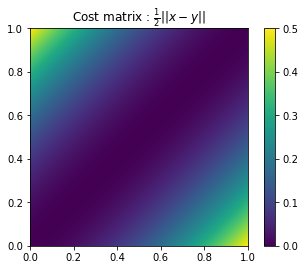

In [7]:
plt.imshow(C, extent=[0,1,0,1], origin="lower")
plt.title("Cost matrix : $\\frac{1}{2}||x-y||$")
plt.colorbar()
plt.show()

We compute the exact solution using the 1d algorithm : in 1d, optimal transport can be solved easily and fast.

In [8]:
cost_exact, plan_exact = sorted1d(C, mu.numpy(), nu.numpy())
display(Markdown(f"The exact cost is {cost_exact:.2e}."))

The exact cost is 7.81e-03.

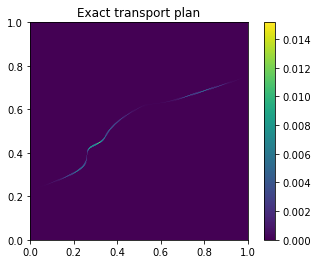

In [9]:
plt.imshow(plan_exact, extent=[0,1,0,1], origin="lower")
plt.title("Exact transport plan")
plt.colorbar()
plt.show()

We calculate an estimated transport map by averaging indexes over dimension 1.

In [10]:
x, Tx = approxmap(plan_exact, a, b, method="averaging")

In [11]:
# Gradient of L2 cost
def Gh(x):
    return x

We use Theorem 1.17 from (Santambrogio, 2015) to compute the gradient of the Kantorovich potential $\phi$ associated with $\nu$, namely :

For the cost $c(x, y) = h(x - y)$, $h$ convex function, and some other boring condition that here we will ignore :
$$\nabla \varphi(x) = \nabla h(x - T(x))$$

In [12]:
Gphi = Gh(x - Tx)

We integrate this gradient to get an estimate of the Kantorovich potential using Trapezoidal method.

We compute $\psi$ using a C-transform.

In [13]:
phi_exact = cumtrapz(Gphi, a, initial=0)
psi_exact = ctransform(C, phi_exact)

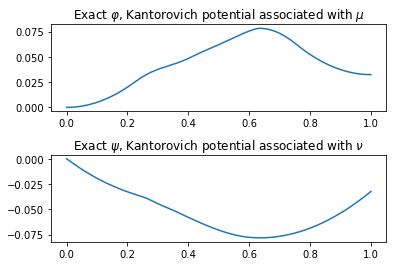

In [14]:
plt.subplot(2,1,1)
plt.title('Exact $\\varphi$, Kantorovich potential associated with $\\mu$')
plt.plot(a, phi_exact)

plt.subplot(2,1,2)
plt.title('Exact $\\psi$, Kantorovich potential associated with $\\nu$')
plt.plot(b, psi_exact)

plt.subplots_adjust(hspace=0.5)
plt.show()

We can check that $$OT(\mu, \nu) = \langle P, C \rangle = \langle \varphi, \mu \rangle + \langle \psi, \nu \rangle$$

In [15]:
cost_kant = np.dot(phi_exact, mu) + np.dot(psi_exact, nu)
display(Markdown(f"The exact cost from Kantorovich potentials is {cost_kant:.2e}."))
display(Markdown(f"The difference from the cost computed from plan is {cost_exact - cost_kant:.2e}."))

The exact cost from Kantorovich potentials is 7.81e-03.

The difference from the cost computed from plan is 5.02e-07.

This difference can be explained from accumulated approximation errors while calculating both Kantorovich potentials.

Below we will compute the Kantorovich potentials for the regularized transport problem (see Sinkhorn notebook) for different values of epsilon.

In [16]:
phis_sinkhorn = dict()
psis_sinkhorn = dict()

alpha = tf.ones((n,), dtype=tf.float64)/n
beta = tf.ones((m,), dtype=tf.float64)/m

epss = np.logspace(-2, -4, 5)
epss = tf.cast(epss, tf.float64)

for eps in epss:
    alpha, beta = sinkhorn_log(C, mu, nu, alpha0=alpha, beta0=beta, eps=eps)
    phis_sinkhorn[float(eps)] = alpha
    psis_sinkhorn[float(eps)] = beta

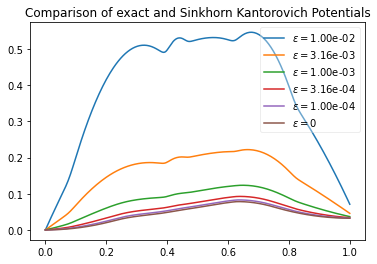

In [17]:
for eps, phi_sinkhorn in phis_sinkhorn.items():
    plt.plot(a, phi_sinkhorn-phi_sinkhorn[0], label=f"$\\varepsilon=${eps:.2e}")
plt.plot(a, phi_exact, label="$\\varepsilon=$0")
plt.title('Comparison of exact and Sinkhorn Kantorovich Potentials')
plt.legend(loc="upper right", framealpha=0.35)
plt.show()

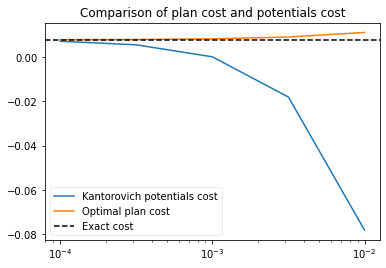

In [18]:
costs_low = np.zeros((5,), dtype=np.float64)
costs_high = np.zeros((5,), dtype=np.float64)
for i, eps in enumerate(epss):
    sinkhorn_plan_log = sinkhornplan(C, eps, phis_sinkhorn[float(eps)], psis_sinkhorn[float(eps)])
    
    costs_low[i] = tf.linalg.tensordot(phis_sinkhorn[float(eps)], mu, 1) + tf.linalg.tensordot(psis_sinkhorn[float(eps)], nu, 1)
    costs_high[i] = tf.math.reduce_sum(tf.math.multiply(sinkhorn_plan_log, C))
    
plt.plot(epss, costs_low, label="Kantorovich potentials cost")
plt.plot(epss, costs_high, label="Optimal plan cost")
plt.axhline(y=float(cost_exact), linestyle="--", c="black", label="Exact cost")
plt.title('Comparison of plan cost and potentials cost')
plt.xscale("log")
plt.legend(loc="lower left", framealpha=0.35)
plt.show()

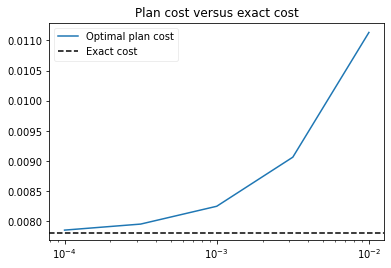

In [19]:
plt.plot(epss, costs_high, label="Optimal plan cost")
plt.axhline(y=float(cost_exact), linestyle="--", c="black", label="Exact cost")
plt.title('Plan cost versus exact cost')
plt.xscale("log")
plt.legend(loc="upper left", framealpha=0.35)
plt.show()

In [43]:
from refldesign.logged.solvers import sinkhorn_log as sinkhorn_log_logged
logs = dict()
epss = np.logspace(-2, -4, 5)
epss = tf.cast(epss, tf.float64)
for eps in epss:
    alpha, beta, runlog = sinkhorn_log_logged(C, mu, nu, eps=eps, maxiter=1000)
    logs[float(eps)] = runlog

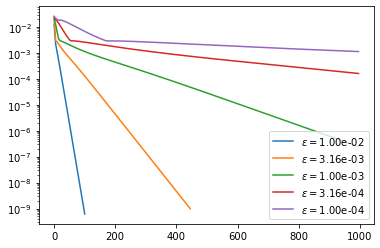

In [52]:
for i, eps in enumerate(epss):
    plt.plot(logs[float(eps)]["iternum"], logs[float(eps)]["margerr"], label=f"$\\varepsilon=${eps:.2e}")
plt.legend(loc="lower right")
plt.yscale("log")

In [77]:
from refldesign.logged.solvers import epsilon_scaling as epsilon_scaling_logged
_, _, _, _, _, runlog = epsilon_scaling_logged(C, mu, nu, 5, eps0=0.01, lbd=0.5, tau=1e3, epscor=True)

In [78]:
_, _, _, _, _, runlognocor = epsilon_scaling_logged(C, mu, nu, 5, eps0=0.01, lbd=0.5, tau=1e3, epscor=False)

In [79]:
%matplotlib qt
plt.plot(runlog["iternum"], runlog["margerr"], label="Correction")
plt.plot(runlognocor["iternum"], runlognocor["margerr"], label="No correction")
plt.xlabel("Number of iterations")
plt.ylabel("Marginal error on $\\mu$")
plt.legend()
plt.yscale("log")